In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

## 1.1 Utility Functions

In [2]:
import gzip
       
def extract_data(filename, num_images, IMAGE_WIDTH):
    '''
    Extract images by reading the file bytestream. Reshape the read values into a 3D matrix of dimensions [m, h, w], where m 
    is the number of training examples.
    '''
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_WIDTH * IMAGE_WIDTH * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH*IMAGE_WIDTH)
        return data

def extract_labels(filename, num_images):
    '''
    Extract label into vector of integer values of dimensions [m, 1], where m is the number of images.
    '''
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

def initializeFilter(size, scale = 1.0):
    stddev = scale/np.sqrt(np.prod(size))
    return np.random.normal(loc = 0, scale = stddev, size = size)

def initializeWeight(size):
    return np.random.standard_normal(size=size) * 0.01

def nanargmax(arr):
    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs    

def softmax(X):
    out = np.exp(X)
    return out/np.sum(out)

def categoricalCrossEntropy(probs, label):
    return -np.sum(label * np.log(probs))

def predict(image, model):
    '''
    Make predictions with trained model. 
    '''
    out = model.forward(image)
    probs = softmax(out) # predict class probabilities with the softmax activation function
    
    return np.argmax(probs), np.max(probs)

## 1.2 Useful Layers (similar to `torch.nn`)

In [3]:
# prototype
class Layer:
    def __init__(self):
        return

    def forward(self, x):
        return None

    def backward(self, dprev, orig):
        return None, None, None

    def getParam(self):
        return []


class Conv2d(Layer):
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1):
        # for sake of simplicity, we assume a square filter
        self.filter = initializeFilter((out_channels, in_channels, kernel_size, kernel_size))
        self.bias = np.zeros((self.filter.shape[0],1))
        self.stride = stride

    def forward(self, x):
        (n_f, n_c_f, f, f2) = self.filter.shape     # filter dimensions (assuming square filters)
        n_c, in_dim, in_dim2 = x.shape              # image dimensions (assuming square images)
        s = self.stride

        assert in_dim == in_dim2, "A square input is required"
        assert f == f2, "A square filter is required"
        assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"
        
        out_dim = int((in_dim - f)/s)+1             # output dimensions
        out = np.zeros((n_f,out_dim,out_dim))
        
        # convolve the filter over every part of the image, adding the bias at each step. 
        for cur in range(n_f):
            for i in range(out_dim):
                for j in range(out_dim):
                    out[cur, i, j] = np.sum(self.filter[cur] * x[:,i * s:i * s+f, j * s:j * s+f]) + self.bias[cur]
        return out

    def backward(self, dprev, orig):
        (n_f, n_c, f, _) = self.filter.shape
        (_, prev_dim, _) = dprev.shape
        (_, orig_dim, _) = orig.shape
        s = self.stride
        ## initialize derivatives
        dout = np.zeros(orig.shape) 
        dfilter = np.zeros(self.filter.shape)
        dbias = np.zeros((n_f,1))

        for cur in range(n_f):
            for i in range(prev_dim):
                for j in range(prev_dim):
                    # loss gradient of filter (used to update the filter)
                    dfilter[cur] += dprev[cur, i, j] * orig[:, i*s:i*s+f, j*s:j*s+f]
                    # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                    dout[:, i*s:i*s+f, j*s:j*s+f] += dprev[cur, i, j] * self.filter[cur] 
            # loss gradient of the bias
            dbias[cur] = np.sum(dprev[cur])
        
        return dout, dfilter, dbias

    def getParam(self):
        return [self.filter, self.bias]

class MaxPool2d(Layer):
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
    
    def forward(self, x):
        n_c, h_prev, w_prev = x.shape
        f = self.kernel_size
        s = self.stride

        h = int((h_prev - f)/s)+1
        w = int((w_prev - f)/s)+1
        
        downsampled = np.zeros((n_c, h, w))
        # slide maxpool window over each part of the image and assign the max value at each step to the output
        for cur in range(n_c):
            for i in range(h):
                for j in range(w):
                    downsampled[cur, i, j] = np.max(x[cur, i*s:i*s+f, j*s:j*s+f])        
        return downsampled

    def backward(self, dprev, orig):
        (n_c, orig_dim, _) = orig.shape
        (_, prev_dim, _) = dprev.shape
        dout = np.zeros(orig.shape)
        f = self.kernel_size
        s = self.stride
        
        for cur in range(n_c):
            for i in range(prev_dim):
                for j in range(prev_dim):
                    # obtain index of largest value in input for current window
                    (a, b) = nanargmax(orig[cur, i*s:i*s+f, j*s:j*s+f])
                    dout[cur, i*s+a, j*s+b] = dprev[cur, i, j]
        return dout, None, None

    def getParam(self):
        return []

class Linear(Layer):
    def __init__(self, in_dim, out_dim):
        self.w = initializeWeight((out_dim, in_dim))
        self.b = np.zeros((self.w.shape[0], 1))

    def forward(self, x):
        return self.w.dot(x) + self.b

    def backward(self, dprev, orig):
        dw = dprev.dot(orig.T)
        db = np.sum(dprev, axis=1).reshape(self.b.shape)
        dout = self.w.T.dot(dprev)

        return dout, dw, db

    def getParam(self):
        return [self.w, self.b]

class ReLU(Layer):
    def __init__(self):
        pass

    def forward(self, x):
        x[x<=0] = 0
        return x

    def backward(self, dprev, orig):
        assert dprev.shape == orig.shape
        dprev[orig<=0] = 0
        return dprev, None, None

    def getParam(self):
        return []

class Flatten(Layer):
    def __init__(self):
        pass

    def forward(self, x):
        return x.reshape((-1,1))

    def backward(self, dprev, orig):
        assert dprev.shape == orig.reshape((-1,1)).shape
        return dprev.reshape(orig.shape), None, None

    def getParam(self):
        return []

## 1.3 Sequential Model (similar to `torch.nn.Sequential`)

In [4]:
import pickle
class Model:
    def __init__(self, layers):
        self.layers = layers
        self.caches = []

    def forward(self, x):
        for layer in self.layers:
            self.caches.append(x)
            x = layer.forward(x)
        return x

    def backward(self, dprev):
        grads = []
        for layer, cache in zip(self.layers[::-1], self.caches[::-1]):
            dprev, dw, db = layer.backward(dprev, cache)
            if dw is not None:
                grads += [db, dw] # we will eventually revert the order
        
        self.caches = []
        return dprev, grads[::-1]

    def getParam(self):
        params = []
        for layer in self.layers:
            params += layer.getParam()
        return params
    
    def saveModel(self, save_path):
        params = self.getParam()
        with open(save_path, 'wb') as file:
            pickle.dump(params, file)

    def loadModel(self, load_path):
        params = self.getParam()
        params[:] = pickle.load(open(load_path, 'rb'))

## 1.4 Adam Optimizer (similar to `torch.Adam`)

In [5]:
from tqdm.notebook import tqdm
def adamGD(model, batch, lr, img_channel=1, img_dim=28, beta1=0.95, beta2=0.99):
    '''
    update the parameters through Adam gradient descnet.
    '''
    X = batch[:,0:-1] # get batch inputs
    X = X.reshape(len(batch), img_channel, img_dim, img_dim)
    Y = batch[:,-1] # get batch labels
    
    cost = 0
    batch_size = len(batch)
    
    
    params = model.getParam()
    # initialize gradients (total_grads), momentum (vs) and RMS params (ss)
    total_grads = []
    vs = []
    ss = []
    for param in params:
        total_grads.append(np.zeros(param.shape))
        vs.append(np.zeros(param.shape))
        ss.append(np.zeros(param.shape))
        
    for i in range(batch_size):
        
        x = X[i]
        y = np.eye(10)[int(Y[i])].reshape(10, 1) # convert label to one-hot
        
        # Forward and Backward
        x = model.forward(x)
        probs = softmax(x)   # categorical cross-entropy loss
        loss = categoricalCrossEntropy(probs, y)
        dout = probs - y # derivative of loss w.r.t. final dense layer output
        _, grads = model.backward(dout)

        for total_grad, grad in zip(total_grads, grads):
            total_grad += grad

        cost += loss

    for p, g, v, s in zip(params, total_grads, vs, ss):
        v = beta1*v + (1-beta1)*g/batch_size        # momentum update
        s = beta2*s + (1-beta2)*(g/batch_size)**2   # RMSProp update
        p -= lr * v/np.sqrt(s+1e-7)                 # Parameter Update

    cost = cost/batch_size
    
    return cost

## 1.5 Data Preprocessing and Model Building

In [9]:
X = extract_data('train-images-idx3-ubyte.gz', num_images=50000, IMAGE_WIDTH=28)
y_dash = extract_labels('train-labels-idx1-ubyte.gz', num_images=50000).reshape(50000,1)
X-= int(np.mean(X))
X/= int(np.std(X))
train_data = np.hstack((X,y_dash))
np.random.shuffle(train_data)

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz


In [10]:
model = Model([
    Conv2d(in_channels=1,out_channels=8),
    ReLU(),
    Conv2d(in_channels=8,out_channels=8),
    ReLU(),
    MaxPool2d(),
    Flatten(),
    Linear(in_dim=800,out_dim=128),
    ReLU(),
    Linear(in_dim=128,out_dim=10)
])

## 1.6 Training Process

In [11]:
batch_size = 32
num_epochs = 3
costs = []

for epoch in range(num_epochs):
    batches = [train_data[k:k + batch_size] for k in range(0, train_data.shape[0], batch_size)]

    t = tqdm(batches)
    for x,batch in enumerate(t):
        cost = adamGD(model, batch, lr=0.01)
        t.set_description("Cost: %.4f" % (cost))
        costs.append(cost)

<IPython.core.display.Javascript object>


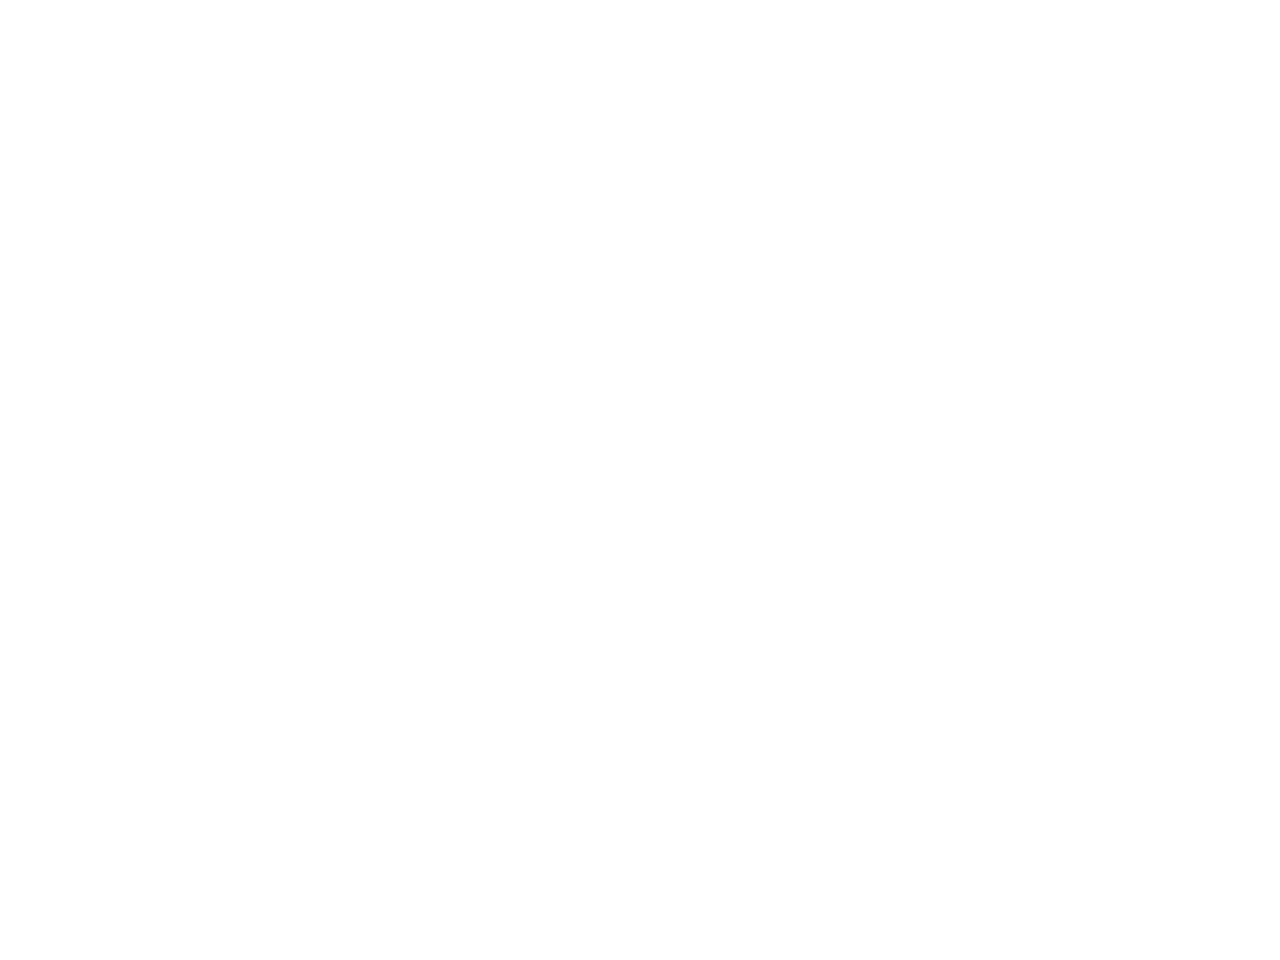

In [12]:
# Plot cost 
plt.plot(costs, 'r')
plt.xlabel('# Iterations')
plt.ylabel('Cost')
plt.legend('Loss', loc='upper right')
plt.show()

In [13]:
model.saveModel("cnn.pkl")

## 1.7 Testing Process

In [14]:
test_model = Model([
    Conv2d(in_channels=1,out_channels=8),
    ReLU(),
    Conv2d(in_channels=8,out_channels=8),
    ReLU(),
    MaxPool2d(),
    Flatten(),
    Linear(in_dim=800,out_dim=128),
    ReLU(),
    Linear(in_dim=128,out_dim=10)   
])
test_model.loadModel("cnn.pkl")

In [15]:
# Get test data
m = 10000
X = extract_data('t10k-images-idx3-ubyte.gz', m, 28)
y_dash = extract_labels('t10k-labels-idx1-ubyte.gz', m).reshape(m,1)

# Normalize the data
X-= int(np.mean(X)) # subtract mean
X/= int(np.std(X)) # divide by standard deviation
test_data = np.hstack((X,y_dash))

X = test_data[:,0:-1]
X = X.reshape(len(test_data), 1, 28, 28)
y = test_data[:,-1]

corr = 0
digit_count = [0 for i in range(10)]
digit_correct = [0 for i in range(10)]

print()
print("Computing accuracy over test set:")

t = tqdm(range(len(X)), leave=True)

for i in t:
    x = X[i]
    pred, prob = predict(x, test_model)
    digit_count[int(y[i])]+=1
    if pred==y[i]:
        corr+=1
        digit_correct[pred]+=1

    t.set_description("Acc:%0.2f%%" % (float(corr/(i+1))*100))

print("Overall Accuracy: %.2f" % (float(corr/len(test_data)*100)))
x = np.arange(10)
digit_recall = [x/y for x,y in zip(digit_correct, digit_count)]
plt.xlabel('Digits')
plt.ylabel('Recall')
plt.title("Recall on Test Set")
plt.bar(x,digit_recall)
plt.show()

Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz

Computing accuracy over test set:



Overall Accuracy: 98.40
